# Overview

This notebook builds and evaluates a **distance‑3 planar surface code** in Qiskit.

- Construct the d=3 layout (data qubits and stabilizer ancillas) and circuits for **single‑round** and **k‑round (space–time)** syndrome extraction.
- Define a simple depolarising **noise model** with readout error.
- Implement lightweight **MWPM decoders**: 2D for single‑round and 3D (space–time) for time‑differenced syndromes.
- Run **Monte‑Carlo sweeps** over physical error rate and compare logical‑X / logical‑Z failure rates.
- Generate a **comparison plot**: single‑round vs space–time decoding.

## Reproduce

- Python ≥ 3.9
- Install deps:
```bash
pip install qiskit networkx numpy matplotlib
```
- Then run this notebook top‑to‑bottom. For a quick demo, keep the defaults; for a longer run, increase `shots` in the **Simulation** section.


In [44]:
# d=3 planar code: 3x3 data qubits, 4 X- and 4 Z-stabilizers (ancillas)

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error, ReadoutError
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Table of Contents

- [1. Data Structure](#data)
- [2. Syndrome Extraction](#syndrome)
- [3. Depolarising Noise Model](#noise)
- [4. MWPM Decoder Scaffold](#decoder)
- [5. Evaluation Metrics](#eval)
- [6. Simulations](#sim)

<a id="data"></a>
# 1. Data Structure

Define the d=3 planar code geometry: map data‑qubit indices on a 3×3 grid, list the four 2×2 plaquettes.

In [45]:
# map (r,c) -> linear index 0..8 for data qubits
def d_idx(r, c): 
    return 3*r + c  # rows 0..2, cols 0..2

# each X and Z plaquette touches a 2x2 block of data qubits
PLAQS = [
    [(0,0),(0,1),(1,0),(1,1)],
    [(0,1),(0,2),(1,1),(1,2)],
    [(1,0),(1,1),(2,0),(2,1)],
    [(1,1),(1,2),(2,1),(2,2)],
]

# 2. Syndrome Extraction
<a id="syndrome"></a>

Syndrome Extraction (one round)

In [46]:
def one_round_surface_d3():
    """
    Returns a circuit with:
      - 9 data qubits
      - 4 X-ancillas (indices 9..12), 4 Z-ancillas (indices 13..16)
      - 8 classical bits storing [X syndromes | Z syndromes]
    """
    n_data = 9
    n_x = 4
    n_z = 4
    x_start = n_data                  # 9..12
    z_start = n_data + n_x            # 13..16

    qreg = QuantumRegister(n_data + n_x + n_z, "q")
    creg = ClassicalRegister(n_x + n_z, "syn")  # [X | Z]
    qc = QuantumCircuit(qreg, creg)

    # --- X stabilizers (measure XXXX) ---
    for s, plaq in enumerate(PLAQS):
        a = x_start + s  # ancilla index
        qc.h(a)          # prepare |+>
        for (r,c) in plaq:
            qc.cx(a, d_idx(r,c))      # CNOT ancilla -> data (parity of X)
        qc.h(a)                       # return to Z basis
        qc.measure(a, s)              # measure into syn[0..3]

    # --- Z stabilizers (measure ZZZZ) ---
    for s, plaq in enumerate(PLAQS):
        a = z_start + s
        for (r,c) in plaq:
            qc.cx(d_idx(r,c), a)      # parity of Z
        qc.measure(a, n_x + s)        # measure into syn[4..7]

    return qc

Syndrome Extraction (space-time encdoing of k rounds) 

In [47]:
# Space-time encoding ensures each round’s ancilla starts clean; XOR of consecutive rounds isolates whether 
# changes came from data errors (flip persists in space) or measurement errors (flip only in time).

In [48]:
# same constants
n_data, n_x, n_z = 9, 4, 4
x_start = n_data          # 9..12
z_start = n_data + n_x    # 13..16

def k_rounds_surface_d3(k: int) -> QuantumCircuit:
    """
    Build d=3 planar surface-code circuit with k rounds of syndrome extraction.
    """
    qreg = QuantumRegister(n_data + n_x + n_z, "q")
    qc = QuantumCircuit(qreg)

    for r in range(k):
        # simple memory error opportunity on data (lets 'id' pick up depolarizing)
        for q in range(9): 
            qc.id(q)
        syn = ClassicalRegister(n_x + n_z, f"syn_{r}")  # 8 bits for this round
        qc.add_register(syn)

        # --- X stabilizers: ancilla -> data (H, CNOTs, H, measure), reset ancilla
        for s, plaq in enumerate(PLAQS):
            a = x_start + s
            qc.reset(qreg[a])
            qc.h(qreg[a])
            for (row, col) in plaq:
                qc.cx(qreg[a], qreg[d_idx(row, col)])
            qc.h(qreg[a])
            qc.measure(qreg[a], syn[s])  # X syndrome bit s
            # (reset done above; no reset after measure needed)

        # --- Z stabilizers: data -> ancilla (CNOTs), measure, reset ancilla
        for s, plaq in enumerate(PLAQS):
            a = z_start + s
            qc.reset(qreg[a])
            for (row, col) in plaq:
                qc.cx(qreg[d_idx(row, col)], qreg[a])
            qc.measure(qreg[a], syn[n_x + s])  # Z syndrome bit s

    return qc

# 3. Depolarising Noise Model
<a id="noise"></a>

In [49]:
def depol_noise_model(p1=0.005, p2=None, ro=0.02):
    if p2 is None:
        p2 = 2.5 * p1
    nm = NoiseModel()
    
    # 1-qubit depolarizing errors
    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['id', 'h', 'x', 'sx'])
    # 2-qubit depolarizing errors
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    
    # 1-qubit readout error (must add per qubit)
    ro_err = ReadoutError([[1-ro, ro], [ro, 1-ro]])
    ancillas = list(range(9, 17))
    for q in ancillas:
        nm.add_readout_error(ro_err, [q])  # add individually
    
    return nm

# 4. MWPM Decoder Scaffold
<a id="decoder"></a>

In [50]:
# Minimum-Weight Perfect Matching tries to pair up all defects with the shortest possible correction paths.
# Each defect is represented as a node in a graph and edge weights = “cost” (distance) between two defects.
# If have an odd number of defects, add a boundary node (B).

# e.g. (a0, a3) — connect defect 0 to defect 3 with a correction chain.
#      (a2, B) — connect defect 2 to the nearest boundary.

In [51]:
# Pseudocode
# INPUT: Zbits from last round (4 bits, one per Z plaquette)
# 1. Find defects = indices of '1' bits
# 2. Make graph G, nodes = defect labels ('a0', 'a1', ...)
# 3. If odd number of defects → add boundary node 'B'
# 4. Connect all pairs with edges weighted by distance
# 5. Run MWPM → get matched pairs
# 6. These pairs = correction paths to apply

In [52]:
# ancilla positions for the 4 plaquettes (both X and Z stabilizers share geometry on d=3)
# centers at (row+0.5, col+0.5) for the four 2x2 blocks:
ANC_POS = [(0.5,0.5), (0.5,1.5), (1.5,0.5), (1.5,1.5)]  # indices 0..3

# boundaries:
TOP_Y, BOT_Y = -0.5, 2.5          # rough (Z-syndrome → correct X errors → logical X)
LEFT_X, RIGHT_X = -0.5, 2.5       # smooth (X-syndrome → correct Z errors → logical Z)
GRID_SPAN = 3.0                   # distance across the code (rows or cols 0..2 → span ~3)

In [53]:
# helpers

def split_into_rounds(bitstr: str, k: int) -> list[str]:
    """Split concatenated classical bits into k chunks of 8 bits (X then Z for each round)."""
    s = bitstr.replace(' ', '')[::-1]     # Qiskit returns little-endian
    return [s[i*8:(i+1)*8] for i in range(k)]

def parse_round_bits(round_bits: str, n_x: int = 4) -> tuple[str, str]:
    """Return (X_bits, Z_bits) for one round-string of length 8."""
    Xs = round_bits[:n_x]
    Zs = round_bits[n_x:]
    return Xs, Zs

def defects_from_bits(bits):
    """Indices (0..3) where syndrome==1."""
    return [i for i, b in enumerate(bits) if b == '1']

def spacetime_defects(full_bitstr: str, k: int, n_x: int = 4):
    """
    Build defect lists for Z- and X-syndromes by XORing consecutive rounds.
    Returns:
      defects_Z: list[(anc_idx, t)]   # Z-syndrome flips → correct X errors → logical-X test
      defects_X: list[(anc_idx, t)]   # X-syndrome flips → correct Z errors → logical-Z test
    """
    rounds = split_into_rounds(full_bitstr, k)
    syn = np.array([[int(b) for b in rb] for rb in rounds])  # shape (k, 8)

    defects_Z, defects_X = [], []
    for t in range(k - 1):
        # Z part (last 4 bits): detect flips across time
        z_prev = syn[t,   n_x:]
        z_next = syn[t+1, n_x:]
        diffZ = (z_prev != z_next)
        for i, d in enumerate(diffZ):
            if d:
                defects_Z.append((i, t))

        # X part (first 4 bits)
        x_prev = syn[t,   :n_x]
        x_next = syn[t+1, :n_x]
        diffX = (x_prev != x_next)
        for i, d in enumerate(diffX):
            if d:
                defects_X.append((i, t))

    return defects_Z, defects_X

2D MWPM

In [54]:
# 2d MWPM

def manhattan(p, q):
    return abs(p[0]-q[0]) + abs(p[1]-q[1])

def distance_to_vertical_boundary(pos):
    """Distance to nearest TOP/BOTTOM boundary (use y)."""
    return min(abs(pos[0]-TOP_Y), abs(pos[0]-BOT_Y))

def distance_to_horizontal_boundary(pos):
    """Distance to nearest LEFT/RIGHT boundary (use x)."""
    return min(abs(pos[1]-LEFT_X), abs(pos[1]-RIGHT_X))

def mwpm_pairs(defect_idxs, boundary_mode):
    """
    defect_idxs: list of ancilla indices 0..3
    boundary_mode: 'vertical' (TOP/BOTTOM) or 'horizontal' (LEFT/RIGHT)
    returns list of pairs, nodes are 'a{i}' or 'B' (virtual boundary)
    """
    
    if not defect_idxs:
        return [] 

    G = nx.Graph()
    nodes = [f"a{i}" for i in defect_idxs]
    for u in nodes: G.add_node(u)

    # add boundary node for odd count
    add_B = (len(nodes) % 2 == 1)
    if add_B:
        G.add_node('B')

    # complete graph among defects
    for i,u in enumerate(nodes):
        for j,v in enumerate(nodes):
            if j <= i: continue
            w = manhattan(ANC_POS[int(u[1:])], ANC_POS[int(v[1:])])
            G.add_edge(u, v, weight=w)

    # connect defects to boundary with appropriate distance
    if add_B:
        for u in nodes:
            pos = ANC_POS[int(u[1:])]
            w = (distance_to_vertical_boundary(pos) if boundary_mode == 'vertical' 
                 else distance_to_horizontal_boundary(pos))
            G.add_edge(u, 'B', weight=w)

    matching = nx.algorithms.matching.min_weight_matching(G, weight="weight")
    if not matching:
        return []

    # matching is a set of 2-tuples or frozensets; normalize to list of tuples
    pairs = []
    for e in matching:
        if len(e) != 2:    # just in case
            continue
        u, v = tuple(e)    # works for tuple or frozenset
        pairs.append((u, v))
    return pairs

3D MWPM with Space-time Encoding

In [55]:
# 3d MWPM with space-time encoding

def ancilla_pos_3d(idx: int, t: int):
    r, c = ANC_POS[idx]
    return (r, c, t)

def mwpm_3d(defects: list[tuple[int,int]], boundary_mode: str, k: int):
    """
    defects: [(anc_idx, t)] with anc_idx in {0..3}, t in {0..k-2}
    boundary_mode: 'vertical' (for Z-syndrome → X errors) or 'horizontal' (for X-syndrome → Z errors)
    returns list of matched pairs; nodes are 'a{idx}_t{t}' or 'B' (boundary)
    """
    G = nx.Graph()
    nodes = [f"a{a}_t{t}" for (a, t) in defects]
    for u in nodes: G.add_node(u)

    # add virtual boundary if odd number of nodes
    if len(nodes) % 2 == 1:
        G.add_node('B')

    # complete graph among defects with L1 distance in space-time
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if j <= i: continue
            ai, ti = map(int, (u.split('_')[0][1:], u.split('_')[1][1:]))
            aj, tj = map(int, (v.split('_')[0][1:], v.split('_')[1][1:]))
            (ri, ci, ti), (rj, cj, tj) = ancilla_pos_3d(ai, ti), ancilla_pos_3d(aj, tj)
            w = abs(ri - rj) + abs(ci - cj) + abs(ti - tj)
            G.add_edge(u, v, weight=w)

    # connect to spatial boundary (not temporal; shots are fixed-length)
    if 'B' in G.nodes:
        for u in nodes:
            ai, ti = map(int, (u.split('_')[0][1:], u.split('_')[1][1:]))
            r, c = ANC_POS[ai]
            if boundary_mode == 'vertical':
                w = min(abs(r - TOP_Y), abs(r - BOT_Y))
            else:
                w = min(abs(c - LEFT_X), abs(c - RIGHT_X))
            G.add_edge(u, 'B', weight=w)

    matching = nx.algorithms.matching.min_weight_matching(G, weight="weight")
    return list(matching) if matching is not None else []

In [56]:
def correction_spans_code(pairs, boundary_mode: str) -> bool:
    """
    crude homology test for d=3:
    return True if any correction pair likely spans across the code in the relevant direction.
    """
    for u, v in pairs:
        def axis(node):
            if node == 'B':
                return TOP_Y if boundary_mode == 'vertical' else LEFT_X
            idx = int(node.split('_')[0][1:])
            pos = ANC_POS[idx]
            return pos[0] if boundary_mode == 'vertical' else pos[1]

        a, b = axis(u), axis(v)
        if abs(a - b) >= (GRID_SPAN - 1.0):
            return True
    return False

Decoders

In [57]:
def decode_one_shot(bitstr, k=1):
    """
    Returns (logical_X_fail, logical_Z_fail) using the LAST round only.
    """
    rounds = split_into_rounds(bitstr, k)
    Xs, Zs = parse_round_bits(rounds[-1])  # last round
    # Z-syndrome -> correct X errors -> logical-X test (vertical boundaries)
    z_def = defects_from_bits(Zs)
    pairs_xcorr = mwpm_pairs(z_def, boundary_mode='vertical')
    logX = correction_spans_code(pairs_xcorr, boundary_mode='vertical')

    # X-syndrome -> correct Z errors -> logical-Z test (horizontal boundaries)
    x_def = defects_from_bits(Xs)
    pairs_zcorr = mwpm_pairs(x_def, boundary_mode='horizontal')
    logZ = correction_spans_code(pairs_zcorr, boundary_mode='horizontal')

    return int(logX), int(logZ)

In [58]:
def decode_spacetime_one_shot(bitstr: str, k: int) -> tuple[int, int]:
    """
    Returns (logX, logZ): 1 if logical-X/Z failure is detected, else 0.
    """
    defects_Z, defects_X = spacetime_defects(bitstr, k)
    pairs_Z = mwpm_3d(defects_Z, boundary_mode='vertical',   k=k)   # logical-X risk
    pairs_X = mwpm_3d(defects_X, boundary_mode='horizontal', k=k)   # logical-Z risk
    logX = correction_spans_code(pairs_Z, 'vertical')
    logZ = correction_spans_code(pairs_X, 'horizontal')
    return int(logX), int(logZ)

# 5. Evaluation Metrics
<a id="eval"></a>

In [59]:
def logical_failure_rates_single(k=1, shots=4000, p1=0.01, ro=0.0):
    sim = AerSimulator()
    qc = k_rounds_surface_d3(k)
    tc = transpile(qc, sim, basis_gates=['id','rz','sx','x','h','cx','measure'],
                   optimization_level=1)
    nm = depol_noise_model(p1=p1, ro=ro)  # includes readout error

    res = sim.run(tc, shots=shots, noise_model=nm).result()
    counts = res.get_counts()

    failX = failZ = total = 0
    for bitstr, n in counts.items():
        lx, lz = decode_one_shot(bitstr, k=k)   # last-round-only decoder
        failX += lx * n
        failZ += lz * n
        total += n
    return failX/max(1,total), failZ/max(1,total)

In [60]:
# use space-time encoding when k>=3

def logical_failure_rates_spacetime(k=3, shots=4000, p1=0.01, ro=0.01):
    sim = AerSimulator()
    qc = k_rounds_surface_d3(k)
    tc = transpile(qc, sim, basis_gates=['id','rz','sx','x','h','cx','measure'], optimization_level=1)
    nm = depol_noise_model(p1=p1, ro=ro)

    res = sim.run(tc, shots=shots, noise_model=nm).result()
    counts = res.get_counts()

    failX = failZ = total = 0
    for bitstr, n in counts.items():
        lx, lz = decode_spacetime_one_shot(bitstr, k)
        failX += lx * n
        failZ += lz * n
        total += n

    return failX/max(1,total), failZ/max(1,total)

# 6. Simulations
<a id="sim"></a>

1 Round Syndrome Extraction Simulation

In [61]:
sim = AerSimulator()
basis = ['id','rz','sx','x','h','cx','measure']

qc = one_round_surface_d3()
tc = transpile(qc, sim, basis_gates=basis, optimization_level=1)

noise = depol_noise_model(p1=0.01, ro=0.01)   # tweak p1 to see more/less defects
res = sim.run(tc, shots=2000, noise_model=noise).result()
counts = res.get_counts()

print("num distinct syndromes:", len(counts))
list(counts.items())[:5]

# quick parse: convert bitstring 'xxxxzzzz' -> (X_syndrome, Z_syndrome)
def parse_syndrome(bitstr, n_x=4):
    s = bitstr.replace(' ', '')  # just in case
    s = s[::-1]
    return s[:n_x], s[n_x:]

# show top-5 most common syndromes
top = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:5]
for bits, n in top:
    xs, zs = parse_syndrome(bits, 4)
    print(f"{bits:>10}  shots={n:4d}   X={xs}  Z={zs}")

c:\Users\86182\AppData\Local\Programs\Python\Python313\Lib\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


num distinct syndromes: 256
  01110101  shots=  21   X=1010  Z=1110
  11010010  shots=  16   X=0100  Z=1011
  10000010  shots=  15   X=0100  Z=0001
  00111110  shots=  14   X=0111  Z=1100
  00011001  shots=  13   X=1001  Z=1000


K Rounds Simulation (comparing single round vs space-time syndrome extraction)

Plot saved to image-results/6.png


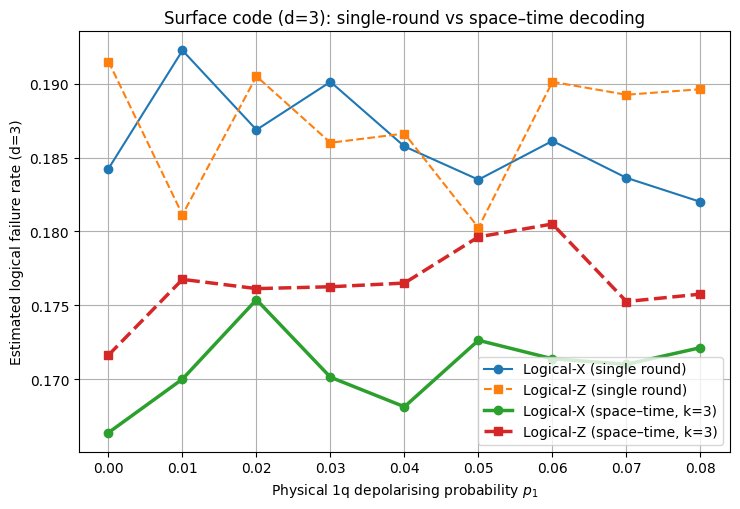

In [71]:
# --- sweep + plot: single-round vs space–time (k>=3 recommended for space-time) ---
def compare_single_vs_spacetime(p_vals, k_space_time=3, k_single=1, shots=6000, ro=0.01):
    pLX_1, pLZ_1, pLX_ST, pLZ_ST = [], [], [], []
    for p in p_vals:
        # single-round baseline
        fx1, fz1 = logical_failure_rates_single(k=k_single, shots=shots, p1=p, ro=ro)
        pLX_1.append(fx1); pLZ_1.append(fz1)
        # space–time (time differencing)
        fxst, fzst = logical_failure_rates_spacetime(k=k_space_time, shots=shots, p1=p, ro=ro)
        pLX_ST.append(fxst); pLZ_ST.append(fzst)
    return (np.array(p_vals),
            np.array(pLX_1), np.array(pLZ_1),
            np.array(pLX_ST), np.array(pLZ_ST))

# run the comparison
p_vals = np.linspace(0.0, 0.08, 9)
ps, pLX_1, pLZ_1, pLX_ST, pLZ_ST = compare_single_vs_spacetime(
    p_vals, k_space_time=3, k_single=1, shots=8000, ro=0.01
)

# plot (optionally save)
save_path = None  # e.g., "image-results/1.png"
plt.figure(figsize=(7.5,5.2))
plt.plot(ps, pLX_1, 'o-',  label='Logical-X (single round)')
plt.plot(ps, pLZ_1, 's--', label='Logical-Z (single round)')
plt.plot(ps, pLX_ST, 'o-',  linewidth=2.5, label='Logical-X (space–time, k=3)')
plt.plot(ps, pLZ_ST, 's--', linewidth=2.5, label='Logical-Z (space–time, k=3)')
plt.xlabel('Physical 1q depolarising probability $p_1$')
plt.ylabel('Estimated logical failure rate (d=3)')
plt.title('Surface code (d=3): single-round vs space–time decoding')
plt.grid(True); plt.legend(); plt.tight_layout()

if save_path:
    import os
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to {save_path}")

plt.show()